# Análisis de Clasificación Multiclase - Yeast Protein Localization
## Proyecto Final - Base de Datos II

Este notebook contiene un análisis exhaustivo del dataset Yeast (UCI ML Repository) aplicando técnicas avanzadas de Machine Learning para clasificación multiclase:

### Técnicas Implementadas:
- **Carga de datos**: Importación oficial desde UCI ML Repository usando `ucimlrepo`
- **Análisis exploratorio**: Estudio del desbalanceo de clases y correlaciones
- **Codificación**: LabelEncoder para variable objetivo categórica
- **Evaluación de escalamiento**: Comparación empírica con/sin StandardScaler
- **Detección de outliers**: PyOD con 3 métodos (KNN, IForest, LOF) protegiendo clases minoritarias
- **Selección de características**: RFE, Lasso (L1), y Forward Stepwise Selection
- **Manejo de desbalanceo**: SMOTE con k_neighbors adaptativo para clases minoritarias
- **Regularización**: Ridge (L2), Lasso (L1), y Elastic Net en Logistic Regression
- **Modelos de clasificación**: Decision Trees, Random Forest, Gradient Boosting, SVM
- **Optimización**: GridSearchCV con cross-validation estratificada
- **Métricas de clasificación**: Accuracy, Balanced Accuracy, F1-Score, Confusion Matrix

### Características del Dataset:
- **Problema**: Clasificación multiclase (10 clases de localización de proteínas)
- **Instancias**: 1,484
- **Características**: 8 (todas numéricas)
- **Desbalanceo**: Severo (clases minoritarias < 5%)
- **Valores faltantes**: 0 (verificado)

## 1. Importar Librerías

In [2]:
# Instalar paquetes necesarios
!pip install pyod ucimlrepo imbalanced-learn mlxtend -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 8.4 MB/s eta 0:00:00


In [4]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Para cargar dataset desde UCI
try:
    from ucimlrepo import fetch_ucirepo
    print("✓ ucimlrepo disponible")
except ImportError:
    print("⚠ Instalar: pip install ucimlrepo")

# Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# Manejo de desbalance
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Detección de outliers
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.lof import LOF

# Selección de características
from sklearn.feature_selection import RFE, RFECV, SelectFromModel, mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Árboles de decisión
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Métricas de CLASIFICACIÓN
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             precision_score, recall_score, f1_score, 
                             roc_auc_score, matthews_corrcoef, cohen_kappa_score,
                             balanced_accuracy_score, make_scorer)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✓ Todas las librerías importadas correctamente")

✓ ucimlrepo disponible
✓ Todas las librerías importadas correctamente


## 2. Carga y Exploración de Datos

In [5]:
# Cargar el dataset desde UCI ML Repository
try:
    from ucimlrepo import fetch_ucirepo
    
    # Cargar dataset oficial
    yeast = fetch_ucirepo(id=110)
    X = yeast.data.features
    y = yeast.data.targets
    
    # Combinar para análisis exploratorio
    df = pd.concat([X, y], axis=1)
    
    print("✓ Dataset cargado desde UCI ML Repository")
    print(f"Dimensiones del dataset: {df.shape}")
    print(f"\nPrimeras filas:")
    display(df.head(10))
except ImportError:
    print("⚠ ucimlrepo no disponible. Instalar con: pip install ucimlrepo")
    raise

✓ Dataset cargado desde UCI ML Repository
Dimensiones del dataset: (1484, 9)

Primeras filas:


,mcg,gvh,alm,mit,erl,pox,vac,nuc,localization_site
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT
5,0.51,0.40,0.56,0.17,0.5,0.5,0.49,0.22,CYT
6,0.50,0.54,0.48,0.65,0.5,0.0,0.53,0.22,MIT
7,0.48,0.45,0.59,0.20,0.5,0.0,0.58,0.34,NUC
8,0.55,0.50,0.66,0.36,0.5,0.0,0.49,0.22,MIT
9,0.40,0.39,0.60,0.15,0.5,0.0,0.58,0.30,CYT


In [6]:
# Información del dataset
print("=" * 60)
print("INFORMACIÓN DEL DATASET")
print("=" * 60)
print(df.info())
print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 60)
display(df.describe())
print("\n" + "=" * 60)
print("VERIFICACIÓN DE VALORES FALTANTES")
print("=" * 60)
missing_total = df.isnull().sum().sum()
print(f"Total de valores faltantes: {missing_total}")
if missing_total == 0:
    print("✓ No hay valores faltantes en el dataset (confirmado por UCI)")

INFORMACIÓN DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mcg                1484 non-null   float64
 1   gvh                1484 non-null   float64
 2   alm                1484 non-null   float64
 3   mit                1484 non-null   float64
 4   erl                1484 non-null   float64
 5   pox                1484 non-null   float64
 6   vac                1484 non-null   float64
 7   nuc                1484 non-null   float64
 8   localization_site  1484 non-null   object 
dtypes: float64(8), object(1)
memory usage: 104.5+ KB
None

ESTADÍSTICAS DESCRIPTIVAS


,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,0.500121,0.499933,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199
std,0.137299,0.123924,0.086670,0.137098,0.048351,0.075683,0.057797,0.106491
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.410000,0.420000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,0.490000,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000
75%,0.580000,0.570000,0.550000,0.320000,0.500000,0.000000,0.530000,0.300000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,0.730000,1.000000



VERIFICACIÓN DE VALORES FALTANTES
Total de valores faltantes: 0
✓ No hay valores faltantes en el dataset (confirmado por UCI)


ANÁLISIS DE DESBALANCEO DE CLASES

Distribución de clases:
localization_site
CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: count, dtype: int64

Número total de clases: 10

Porcentaje por clase:
  CYT: 463 (31.20%)
  NUC: 429 (28.91%)
  MIT: 244 (16.44%)
  ME3: 163 (10.98%)
  ME2: 51 (3.44%)
  ME1: 44 (2.96%)
  EXC: 35 (2.36%)
  VAC: 30 (2.02%)
  POX: 20 (1.35%)
  ERL: 5 (0.34%)

⚠ CLASES MINORITARIAS detectadas (< 5%): 6
  - ME2: 51 instancias
  - ME1: 44 instancias
  - EXC: 35 instancias
  - VAC: 30 instancias
  - POX: 20 instancias
  - ERL: 5 instancias


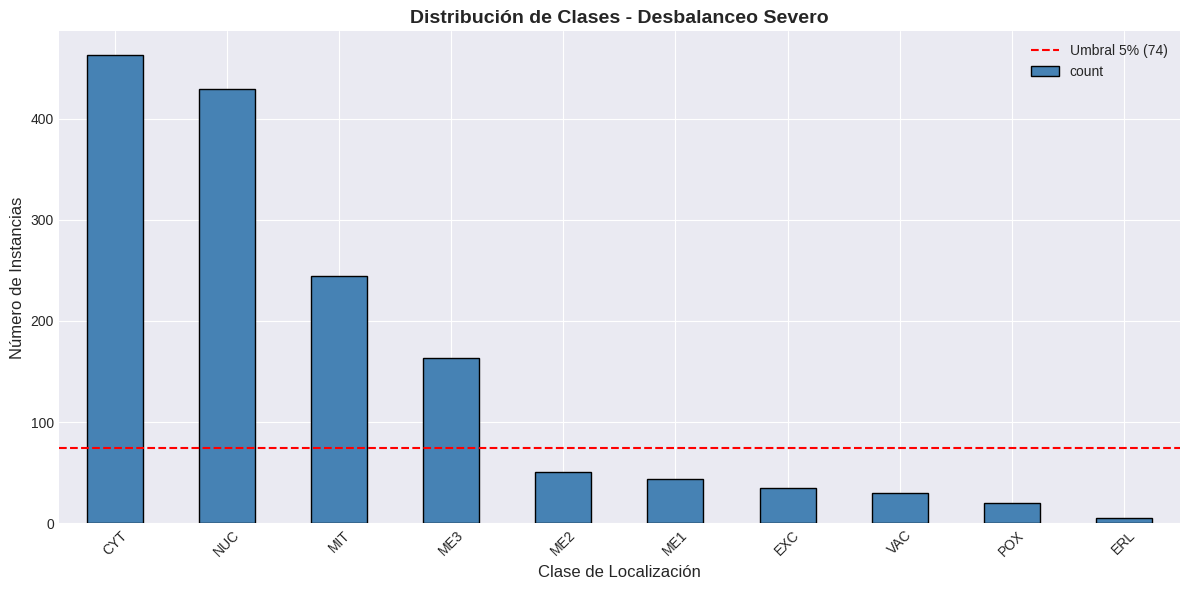

In [7]:
# Análisis de distribución de clases (DESBALANCEO)
print("=" * 60)
print("ANÁLISIS DE DESBALANCEO DE CLASES")
print("=" * 60)
class_counts = df.iloc[:, -1].value_counts().sort_values(ascending=False)
print("\nDistribución de clases:")
print(class_counts)
print(f"\nNúmero total de clases: {df.iloc[:, -1].nunique()}")

# Calcular porcentajes
print("\nPorcentaje por clase:")
for cls, count in class_counts.items():
    pct = (count / len(df)) * 100
    print(f"  {cls}: {count} ({pct:.2f}%)")

# Identificar clases minoritarias (< 5%)
minority_threshold = len(df) * 0.05
minority_classes = class_counts[class_counts < minority_threshold]
print(f"\n⚠ CLASES MINORITARIAS detectadas (< 5%): {len(minority_classes)}")
for cls in minority_classes.index:
    print(f"  - {cls}: {class_counts[cls]} instancias")

# Visualización
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.axhline(y=minority_threshold, color='red', linestyle='--', label=f'Umbral 5% ({minority_threshold:.0f})')
plt.title('Distribución de Clases - Desbalanceo Severo', fontsize=14, fontweight='bold')
plt.xlabel('Clase de Localización', fontsize=12)
plt.ylabel('Número de Instancias', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

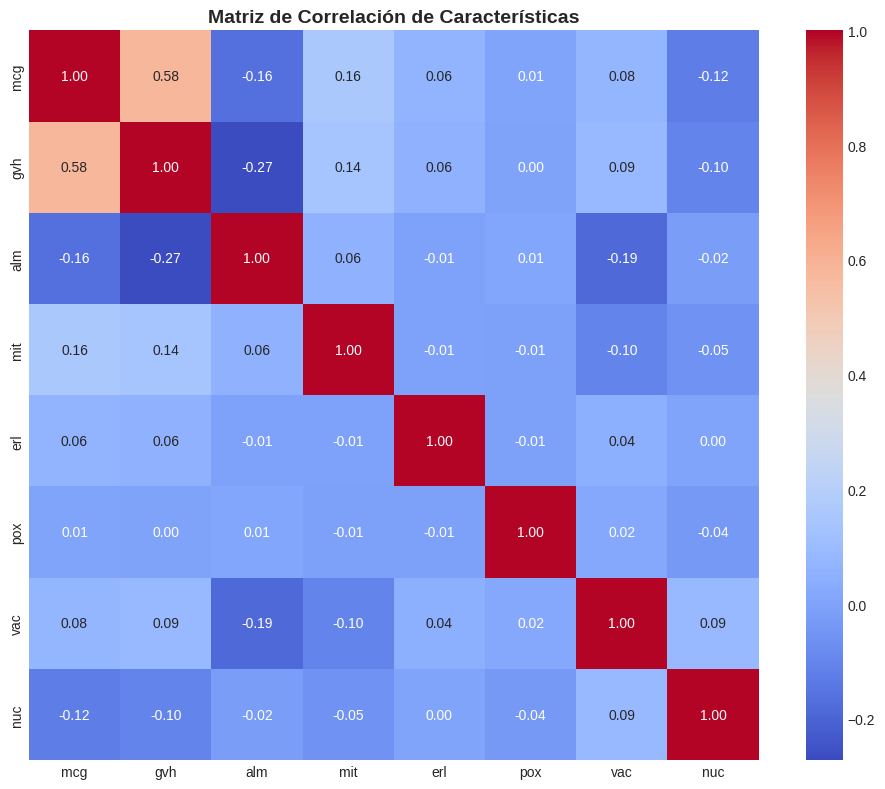

In [8]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matriz de Correlación de Características', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Preparación de Datos

In [9]:
# Separar características y target
X = df.iloc[:, :-1]  # Todas las columnas excepto la última
y = df.iloc[:, -1]   # Última columna (clase)

# Codificar variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("=" * 60)
print("PREPARACIÓN DE DATOS PARA CLASIFICACIÓN")
print("=" * 60)
print(f"Características (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nClases originales → Codificadas:")
for original, encoded in zip(le.classes_, le.transform(le.classes_)):
    print(f"  {original} → {encoded}")
    
# Guardar mapeo para referencia posterior
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"\n✓ Dataset preparado para clasificación multiclase ({len(le.classes_)} clases)")

PREPARACIÓN DE DATOS PARA CLASIFICACIÓN
Características (X): (1484, 8)
Target (y): (1484,)

Clases originales → Codificadas:
  CYT → 0
  ERL → 1
  EXC → 2
  ME1 → 3
  ME2 → 4
  ME3 → 5
  MIT → 6
  NUC → 7
  POX → 8
  VAC → 9

✓ Dataset preparado para clasificación multiclase (10 clases)


## 4. Evaluación de Escalamiento

Evaluar si el escalamiento mejora el rendimiento de los modelos de clasificación.

In [10]:
# Comparar rendimiento con y sin escalamiento
from sklearn.model_selection import cross_val_score

# Split para evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Modelo de referencia: Random Forest (robusto al escalamiento)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Evaluar sin escalamiento
scores_no_scale = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Evaluar con escalamiento StandardScaler
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
scores_std_scale = cross_val_score(rf_model, X_train_std, y_train, cv=5, scoring='accuracy')

print("=" * 60)
print("EVALUACIÓN DE ESCALAMIENTO")
print("=" * 60)
print(f"\nSin escalamiento:")
print(f"  Accuracy promedio: {scores_no_scale.mean():.4f} (±{scores_no_scale.std():.4f})")
print(f"\nCon StandardScaler:")
print(f"  Accuracy promedio: {scores_std_scale.mean():.4f} (±{scores_std_scale.std():.4f})")

if scores_std_scale.mean() > scores_no_scale.mean():
    print(f"\n✓ El escalamiento MEJORA el rendimiento (+{(scores_std_scale.mean() - scores_no_scale.mean())*100:.2f}%)")
    use_scaling = True
else:
    print(f"\n⚠ El escalamiento NO mejora significativamente el rendimiento")
    use_scaling = False

EVALUACIÓN DE ESCALAMIENTO

Sin escalamiento:
  Accuracy promedio: 0.5972 (±0.0344)

Con StandardScaler:
  Accuracy promedio: 0.5963 (±0.0387)

⚠ El escalamiento NO mejora significativamente el rendimiento


## 5. Detección de Outliers con PyOD (Protegiendo Clases Minoritarias)

**IMPORTANTE**: En problemas de clasificación desbalanceados, NO debemos eliminar outliers de clases minoritarias, ya que perderíamos información valiosa.

In [11]:
# Identificar clases minoritarias (< 5% del dataset)
minority_threshold = len(df) * 0.05
class_counts = y.value_counts()
minority_classes = class_counts[class_counts < minority_threshold].index.tolist()

print("=" * 60)
print("ANÁLISIS DE OUTLIERS POR CLASE")
print("=" * 60)
print(f"\nClases minoritarias identificadas: {minority_classes}")
print(f"Total de instancias en clases minoritarias: {class_counts[minority_classes].sum()}")

# Escalar datos para detección
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Detectar outliers con múltiples métodos
knn_detector = KNN(contamination=0.1)
knn_labels = knn_detector.fit_predict(X_scaled)

iforest_detector = IForest(contamination=0.1, random_state=42)
iforest_labels = iforest_detector.fit_predict(X_scaled)

lof_detector = LOF(contamination=0.1)
lof_labels = lof_detector.fit_predict(X_scaled)

# Consenso: outlier si 2 de 3 métodos lo detectan
outlier_votes = knn_labels + iforest_labels + lof_labels
is_outlier = outlier_votes >= 2

print(f"\nOutliers detectados (consenso 2/3): {is_outlier.sum()}")

ANÁLISIS DE OUTLIERS POR CLASE

Clases minoritarias identificadas: ['ME2', 'ME1', 'EXC', 'VAC', 'POX', 'ERL']
Total de instancias en clases minoritarias: 185

Outliers detectados (consenso 2/3): 142

Outliers detectados (consenso 2/3): 142


In [12]:
# Analizar distribución de outliers por clase
outlier_df = pd.DataFrame({
    'class': y,
    'is_outlier': is_outlier
})

print("\n" + "=" * 60)
print("DISTRIBUCIÓN DE OUTLIERS POR CLASE")
print("=" * 60)
for cls in y.unique():
    class_mask = (y == cls)
    n_class = class_mask.sum()
    n_outliers = (is_outlier & class_mask).sum()
    pct_outliers = (n_outliers / n_class) * 100 if n_class > 0 else 0
    is_minority = cls in minority_classes
    
    status = "⚠ MINORITARIA" if is_minority else ""
    print(f"\nClase {cls}: {n_class} instancias {status}")
    print(f"  Outliers detectados: {n_outliers} ({pct_outliers:.2f}%)")

# PROTEGER CLASES MINORITARIAS: No eliminar outliers de ellas
outliers_to_remove = is_outlier.copy()
for cls in minority_classes:
    minority_mask = (y == cls)
    outliers_to_remove[minority_mask] = False
    protected = (is_outlier & minority_mask).sum()
    if protected > 0:
        print(f"\n✓ Protegidos {protected} outliers de la clase minoritaria '{cls}'")

X_clean = X[~outliers_to_remove]
y_clean = y_encoded[~outliers_to_remove]

print(f"\n" + "=" * 60)
print(f"Dataset original: {X.shape}")
print(f"Dataset limpio (protegiendo minoritarias): {X_clean.shape}")
print(f"Outliers removidos: {outliers_to_remove.sum()}")


DISTRIBUCIÓN DE OUTLIERS POR CLASE

Clase MIT: 244 instancias 
  Outliers detectados: 17 (6.97%)

Clase NUC: 429 instancias 
  Outliers detectados: 37 (8.62%)

Clase CYT: 463 instancias 
  Outliers detectados: 30 (6.48%)

Clase ME1: 44 instancias ⚠ MINORITARIA
  Outliers detectados: 8 (18.18%)

Clase EXC: 35 instancias ⚠ MINORITARIA
  Outliers detectados: 4 (11.43%)

Clase ME2: 51 instancias ⚠ MINORITARIA
  Outliers detectados: 10 (19.61%)

Clase ME3: 163 instancias 
  Outliers detectados: 16 (9.82%)

Clase VAC: 30 instancias ⚠ MINORITARIA
  Outliers detectados: 4 (13.33%)

Clase POX: 20 instancias ⚠ MINORITARIA
  Outliers detectados: 11 (55.00%)

Clase ERL: 5 instancias ⚠ MINORITARIA
  Outliers detectados: 5 (100.00%)

✓ Protegidos 10 outliers de la clase minoritaria 'ME2'

✓ Protegidos 8 outliers de la clase minoritaria 'ME1'

✓ Protegidos 4 outliers de la clase minoritaria 'EXC'

✓ Protegidos 4 outliers de la clase minoritaria 'VAC'

✓ Protegidos 11 outliers de la clase minoritaria

## 6. Selección de Características

### 6.1 Método RFE (Recursive Feature Elimination)

RFE es una alternativa robusta a Boruta que elimina recursivamente las características menos importantes.

In [13]:
# RFE (Recursive Feature Elimination) para selección de características
print("Ejecutando RFE para clasificación...")

# Usar RandomForest como estimador (clasificación)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# RFE con cross-validation para seleccionar el número óptimo de características
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_clean, y_clean)

# Características seleccionadas
rfe_selected = X_clean.columns[rfecv.support_].tolist()
rfe_ranking = pd.DataFrame({
    'Feature': X_clean.columns,
    'Ranking': rfecv.ranking_,
    'Selected': rfecv.support_
}).sort_values('Ranking')

print("\n" + "=" * 60)
print("RESULTADOS RFE (CLASIFICACIÓN)")
print("=" * 60)
print(rfe_ranking)
print(f"\n✓ Características seleccionadas: {rfe_selected}")
print(f"✓ Número óptimo de características: {rfecv.n_features_}")
print(f"✓ Accuracy con características seleccionadas: {rfecv.cv_results_['mean_test_score'][rfecv.n_features_ - 1]:.4f}")

Ejecutando RFE para clasificación...

RESULTADOS RFE (CLASIFICACIÓN)
  Feature  Ranking  Selected
0     mcg        1      True
1     gvh        1      True
2     alm        1      True
3     mit        1      True
4     erl        1      True
5     pox        1      True
6     vac        1      True
7     nuc        1      True

✓ Características seleccionadas: ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']
✓ Número óptimo de características: 8
✓ Accuracy con características seleccionadas: 0.6055

RESULTADOS RFE (CLASIFICACIÓN)
  Feature  Ranking  Selected
0     mcg        1      True
1     gvh        1      True
2     alm        1      True
3     mit        1      True
4     erl        1      True
5     pox        1      True
6     vac        1      True
7     nuc        1      True

✓ Características seleccionadas: ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']
✓ Número óptimo de características: 8
✓ Accuracy con características seleccionadas: 0.6055


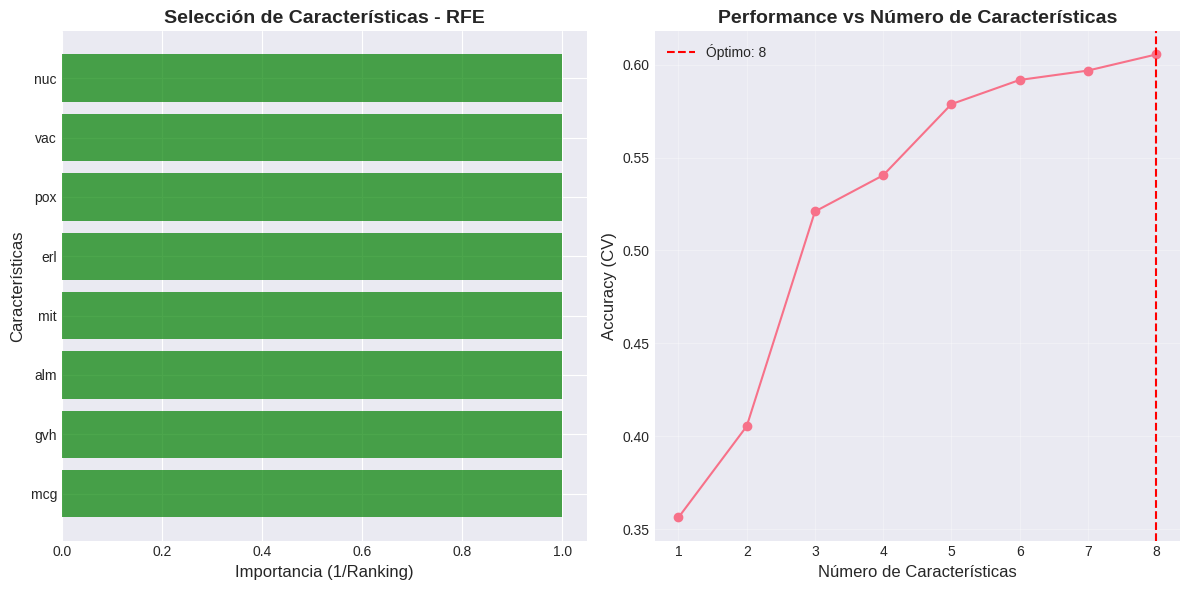

In [14]:
# Visualizar importancia de características según RFE
plt.figure(figsize=(12, 6))

# Subplot 1: Ranking de características
plt.subplot(1, 2, 1)
colors = ['green' if x else 'red' for x in rfe_ranking['Selected']]
plt.barh(rfe_ranking['Feature'], 1/rfe_ranking['Ranking'], color=colors, alpha=0.7)
plt.xlabel('Importancia (1/Ranking)', fontsize=12)
plt.ylabel('Características', fontsize=12)
plt.title('Selección de Características - RFE', fontsize=14, fontweight='bold')

# Subplot 2: Número de características vs Score
plt.subplot(1, 2, 2)
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
         rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel('Número de Características', fontsize=12)
plt.ylabel('Accuracy (CV)', fontsize=12)
plt.title('Performance vs Número de Características', fontsize=14, fontweight='bold')
plt.axvline(x=rfecv.n_features_, color='r', linestyle='--', label=f'Óptimo: {rfecv.n_features_}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.2 Método Lasso (L1) - Regresión Logística para Clasificación

Usamos Logistic Regression con L1 para selección de características en clasificación.

In [15]:
# Lasso (L1) para clasificación: Logistic Regression con regularización L1
scaler_lasso = StandardScaler()
X_scaled_lasso = scaler_lasso.fit_transform(X_clean)

# LogisticRegressionCV con L1 para encontrar el mejor C
lasso_clf = LogisticRegressionCV(
    penalty='l1',
    solver='saga',
    cv=5,
    max_iter=10000,
    random_state=42,
    n_jobs=-1
)
lasso_clf.fit(X_scaled_lasso, y_clean)

# Coeficientes promedio (multiclase)
lasso_coef_avg = np.abs(lasso_clf.coef_).mean(axis=0)
lasso_coef = pd.DataFrame({
    'Feature': X_clean.columns,
    'Coefficient': lasso_coef_avg
}).sort_values('Coefficient', ascending=False)

# Características con coeficiente significativo (> 0.01)
lasso_selected = lasso_coef[lasso_coef['Coefficient'] > 0.01]['Feature'].tolist()

print("=" * 60)
print("LASSO (L1) - CLASIFICACIÓN")
print("=" * 60)
print(f"Mejor C encontrado: {lasso_clf.C_[0]:.4f}")
print(f"Características seleccionadas (coef > 0.01): {len(lasso_selected)}")
print(f"\n{lasso_coef}")

LASSO (L1) - CLASIFICACIÓN
Mejor C encontrado: 2.7826
Características seleccionadas (coef > 0.01): 8

  Feature  Coefficient
0     mcg     1.036458
2     alm     0.801500
1     gvh     0.474300
7     nuc     0.391699
3     mit     0.305993
6     vac     0.222068
4     erl     0.151781
5     pox     0.127484


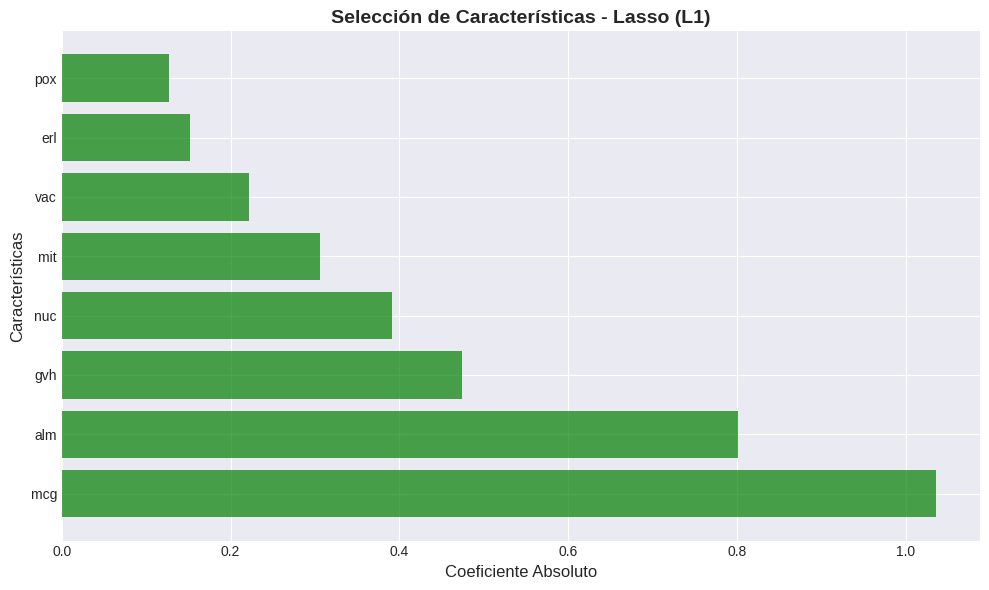

In [16]:
# Visualizar coeficientes Lasso
plt.figure(figsize=(10, 6))
colors_lasso = ['green' if x > 0 else 'red' for x in lasso_coef['Coefficient']]
plt.barh(lasso_coef['Feature'], lasso_coef['Coefficient'], color=colors_lasso, alpha=0.7)
plt.xlabel('Coeficiente Absoluto', fontsize=12)
plt.ylabel('Características', fontsize=12)
plt.title('Selección de Características - Lasso (L1)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 6.3 Método Stepwise (Forward Selection)

In [17]:
# Forward Stepwise Selection para clasificación
print("Ejecutando Forward Stepwise Selection para clasificación...")

rf_stepwise = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Forward selection
sfs_forward = SFS(rf_stepwise, 
                  k_features=5,
                  forward=True, 
                  floating=False, 
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-1)

sfs_forward.fit(X_clean.values, y_clean)

# Características seleccionadas
stepwise_selected_idx = list(sfs_forward.k_feature_idx_)
stepwise_selected = X_clean.columns[stepwise_selected_idx].tolist()

print("=" * 60)
print("STEPWISE FORWARD SELECTION - CLASIFICACIÓN")
print("=" * 60)
print(f"✓ Características seleccionadas: {stepwise_selected}")
print(f"✓ Accuracy Score: {sfs_forward.k_score_:.4f}")

Ejecutando Forward Stepwise Selection para clasificación...
STEPWISE FORWARD SELECTION - CLASIFICACIÓN
✓ Características seleccionadas: ['mcg', 'gvh', 'alm', 'mit', 'nuc']
✓ Accuracy Score: 0.5708
STEPWISE FORWARD SELECTION - CLASIFICACIÓN
✓ Características seleccionadas: ['mcg', 'gvh', 'alm', 'mit', 'nuc']
✓ Accuracy Score: 0.5708


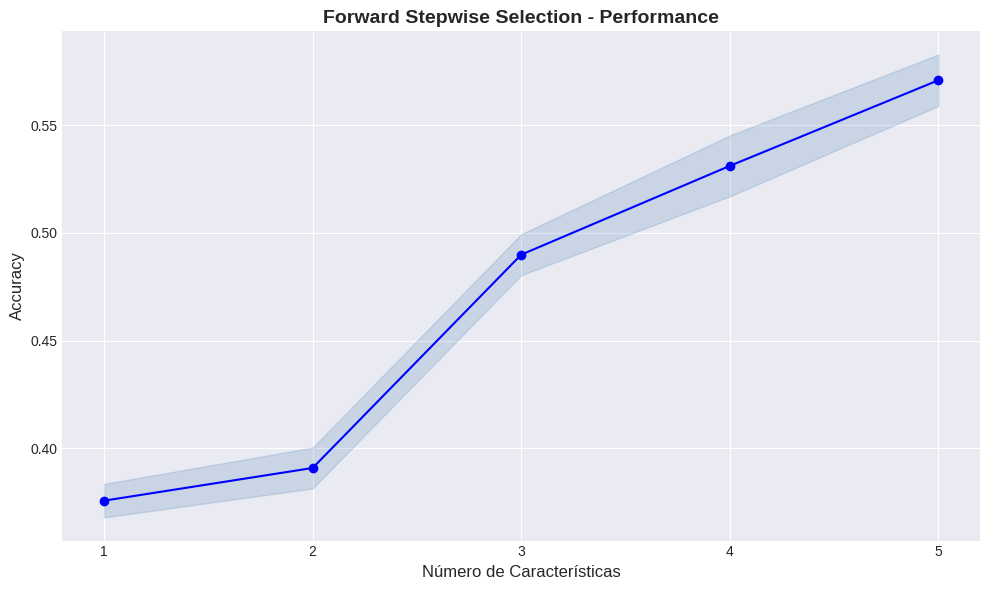

In [18]:
# Visualizar el proceso de selección stepwise
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs_forward.get_metric_dict(), kind='std_err', figsize=(10, 6))
plt.title('Forward Stepwise Selection - Performance', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Número de Características', fontsize=12)
plt.tight_layout()
plt.show()

### 6.4 Comparación de Métodos de Selección

In [19]:
# Comparar características seleccionadas por cada método
print("="*60)
print("COMPARACIÓN DE MÉTODOS DE SELECCIÓN DE CARACTERÍSTICAS")
print("="*60)

print(f"\nRFE: {len(rfe_selected)} características")
print(f"  {rfe_selected}")

print(f"\nLasso: {len(lasso_selected)} características")
print(f"  {lasso_selected}")

print(f"\nStepwise: {len(stepwise_selected)} características")
print(f"  {stepwise_selected}")

# Características en común
common_features = set(rfe_selected) & set(lasso_selected) & set(stepwise_selected)
print(f"\nCaracterísticas seleccionadas por los 3 métodos: {common_features}")

# Unión de todas las características
all_selected = set(rfe_selected) | set(lasso_selected) | set(stepwise_selected)
print(f"\nTotal de características únicas seleccionadas: {len(all_selected)}")
print(f"  {sorted(all_selected)}")

COMPARACIÓN DE MÉTODOS DE SELECCIÓN DE CARACTERÍSTICAS

RFE: 8 características
  ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']

Lasso: 8 características
  ['mcg', 'alm', 'gvh', 'nuc', 'mit', 'vac', 'erl', 'pox']

Stepwise: 5 características
  ['mcg', 'gvh', 'alm', 'mit', 'nuc']

Características seleccionadas por los 3 métodos: {'mit', 'nuc', 'alm', 'mcg', 'gvh'}

Total de características únicas seleccionadas: 8
  ['alm', 'erl', 'gvh', 'mcg', 'mit', 'nuc', 'pox', 'vac']


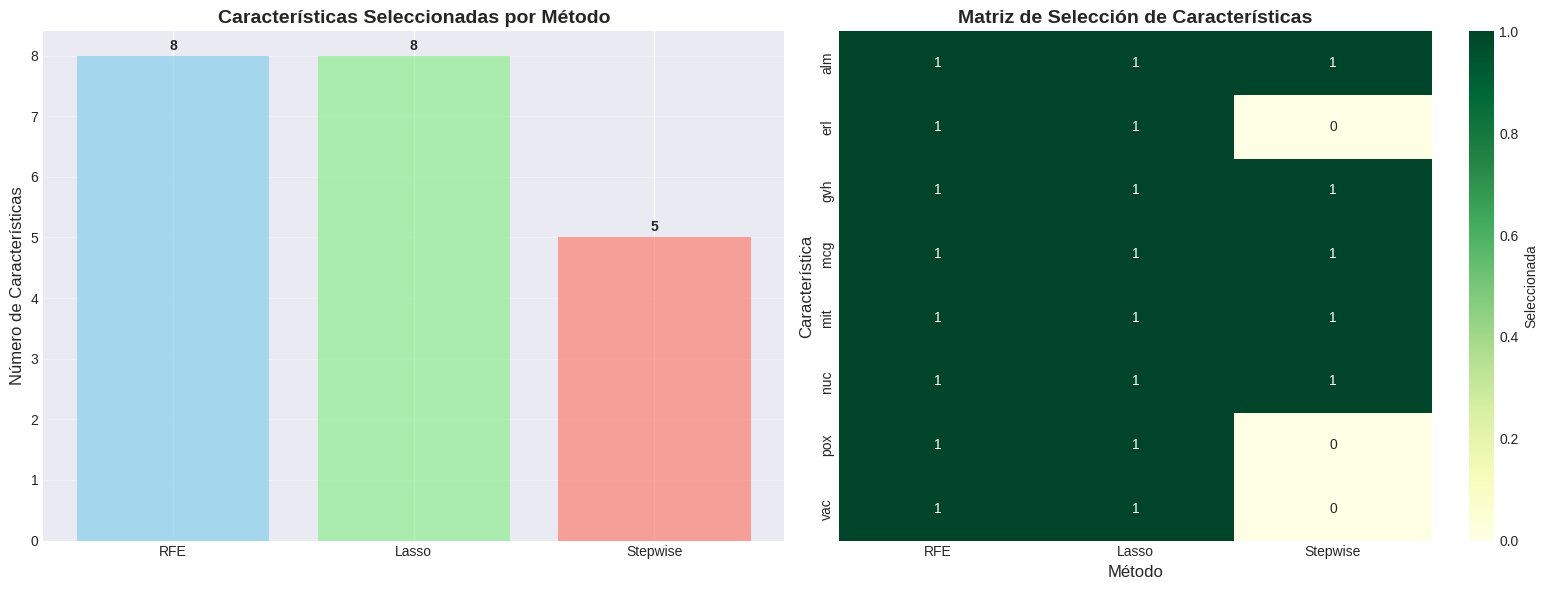

In [20]:
# Visualizar comparación de métodos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Comparación de número de características
method_names = ['RFE', 'Lasso', 'Stepwise']
num_features = [len(rfe_selected), len(lasso_selected), len(stepwise_selected)]
colors_methods = ['skyblue', 'lightgreen', 'salmon']

axes[0].bar(method_names, num_features, color=colors_methods, alpha=0.7)
axes[0].set_ylabel('Número de Características', fontsize=12)
axes[0].set_title('Características Seleccionadas por Método', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(num_features):
    axes[0].text(i, v + 0.1, str(v), ha='center', fontweight='bold')

# Subplot 2: Matriz de selección (heatmap)
all_features = sorted(set(rfe_selected) | set(lasso_selected) | set(stepwise_selected))
selection_matrix = []
for feat in all_features:
    row = [
        1 if feat in rfe_selected else 0,
        1 if feat in lasso_selected else 0,
        1 if feat in stepwise_selected else 0
    ]
    selection_matrix.append(row)

selection_df = pd.DataFrame(selection_matrix, index=all_features, columns=['RFE', 'Lasso', 'Stepwise'])
sns.heatmap(selection_df, annot=True, fmt='d', cmap='YlGn', cbar_kws={'label': 'Seleccionada'}, ax=axes[1])
axes[1].set_title('Matriz de Selección de Características', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Método', fontsize=12)
axes[1].set_ylabel('Característica', fontsize=12)

plt.tight_layout()
plt.show()

## 7. Manejo de Desbalanceo de Clases y Preparación de Modelos

In [21]:
# Preparar datos para modelado
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.3, random_state=42, stratify=y_clean
)

# Escalar datos (si el análisis mostró que es beneficioso)
scaler_model = StandardScaler()
X_train_scaled = scaler_model.fit_transform(X_train)
X_test_scaled = scaler_model.transform(X_test)

print("=" * 60)
print("PREPARACIÓN DE DATOS PARA MODELADO")
print("=" * 60)
print(f"Entrenamiento: {X_train.shape}")
print(f"Prueba: {X_test.shape}")

# Verificar distribución de clases en train
train_class_dist = pd.Series(y_train).value_counts()
print(f"\nDistribución de clases en entrenamiento:")
print(train_class_dist)

PREPARACIÓN DE DATOS PARA MODELADO
Entrenamiento: (968, 8)
Prueba: (416, 8)

Distribución de clases en entrenamiento:
0    303
7    274
6    159
5    103
4     36
3     31
2     24
9     21
8     14
1      3
Name: count, dtype: int64


### 7.1 Técnicas de Balanceo: SMOTE y Oversampling

In [22]:
# Aplicar SMOTE con k_neighbors ajustado para clases muy pequeñas
# Encontrar la clase con menos muestras
min_samples = pd.Series(y_train).value_counts().min()
# SMOTE necesita k_neighbors < min_samples, usar máximo 1 o min_samples-1
k_neighbors = max(1, min(5, min_samples - 1))

print("=" * 60)
print("CONFIGURACIÓN DE BALANCEO")
print("=" * 60)
print(f"Clase con menos muestras: {min_samples} instancias")
print(f"k_neighbors para SMOTE: {k_neighbors}")

try:
    smote = SMOTE(k_neighbors=k_neighbors, random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
    
    print("\n" + "=" * 60)
    print("BALANCEO CON SMOTE")
    print("=" * 60)
    print(f"Antes de SMOTE: {X_train_scaled.shape}")
    print(f"Después de SMOTE: {X_train_smote.shape}")
    
    print("\nDistribución de clases después de SMOTE:")
    smote_class_dist = pd.Series(y_train_smote).value_counts()
    print(smote_class_dist)
    
    # Usar SMOTE como estrategia principal
    X_train_balanced = X_train_smote
    y_train_balanced = y_train_smote
    balancing_method = "SMOTE"
    
except ValueError as e:
    print(f"\n⚠ SMOTE falló: {str(e)}")
    print("Usando Random Oversampling como alternativa...")
    
    # Alternativa: Random Oversampling (funciona con cualquier cantidad de muestras)
    ros = RandomOverSampler(random_state=42)
    X_train_ros, y_train_ros = ros.fit_resample(X_train_scaled, y_train)
    
    print("\n" + "=" * 60)
    print("BALANCEO CON RANDOM OVERSAMPLING")
    print("=" * 60)
    print(f"Antes de ROS: {X_train_scaled.shape}")
    print(f"Después de ROS: {X_train_ros.shape}")
    print(f"\nDistribución de clases después de ROS:")
    print(pd.Series(y_train_ros).value_counts())
    
    # Usar Random Oversampling
    X_train_balanced = X_train_ros
    y_train_balanced = y_train_ros
    balancing_method = "Random Oversampling"

print(f"\n✓ Usando {balancing_method} para entrenamiento balanceado")

CONFIGURACIÓN DE BALANCEO
Clase con menos muestras: 3 instancias
k_neighbors para SMOTE: 2

BALANCEO CON SMOTE
Antes de SMOTE: (968, 8)
Después de SMOTE: (3030, 8)

Distribución de clases después de SMOTE:
7    303
0    303
6    303
4    303
5    303
3    303
8    303
9    303
2    303
1    303
Name: count, dtype: int64

✓ Usando SMOTE para entrenamiento balanceado


### 7.2 Modelos con Regularización L2 (Ridge) - Logistic Regression

In [23]:
# Logistic Regression con regularización L2 (Ridge)
ridge_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_clf = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000, random_state=42)
ridge_grid = GridSearchCV(ridge_clf, ridge_params, cv=5, scoring='accuracy', n_jobs=-1)
ridge_grid.fit(X_train_balanced, y_train_balanced)

print("=" * 60)
print("RIDGE (L2) - CLASIFICACIÓN")
print("=" * 60)
print(f"Mejor C: {ridge_grid.best_params_['C']}")
print(f"Mejor Accuracy (CV): {ridge_grid.best_score_:.4f}")

# Predicciones
ridge_pred = ridge_grid.predict(X_test_scaled)
ridge_acc = accuracy_score(y_test, ridge_pred)
ridge_f1 = f1_score(y_test, ridge_pred, average='weighted')

print(f"\nMétricas en Test:")
print(f"  Accuracy: {ridge_acc:.4f}")
print(f"  F1-Score (weighted): {ridge_f1:.4f}")
print(f"\nReporte de clasificación:")
print(classification_report(y_test, ridge_pred, zero_division=0))

RIDGE (L2) - CLASIFICACIÓN
Mejor C: 1
Mejor Accuracy (CV): 0.6413

Métricas en Test:
  Accuracy: 0.4712
  F1-Score (weighted): 0.4862

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.46      0.25      0.32       130
           1       1.00      1.00      1.00         2
           2       0.35      0.55      0.43        11
           3       0.56      0.77      0.65        13
           4       0.44      0.47      0.45        15
           5       0.69      0.84      0.76        44
           6       0.56      0.63      0.59        68
           7       0.60      0.47      0.52       118
           8       0.50      0.67      0.57         6
           9       0.00      0.00      0.00         9

    accuracy                           0.47       416
   macro avg       0.51      0.56      0.53       416
weighted avg       0.53      0.47      0.49       416



### 7.3 Modelos con Regularización L1 (Lasso) - Logistic Regression

In [24]:
# Logistic Regression con regularización L1 (Lasso)
lasso_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_clf = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, random_state=42)
lasso_grid = GridSearchCV(lasso_clf, lasso_params, cv=5, scoring='accuracy', n_jobs=-1)
lasso_grid.fit(X_train_balanced, y_train_balanced)

print("=" * 60)
print("LASSO (L1) - CLASIFICACIÓN")
print("=" * 60)
print(f"Mejor C: {lasso_grid.best_params_['C']}")
print(f"Mejor Accuracy (CV): {lasso_grid.best_score_:.4f}")

# Predicciones
lasso_pred = lasso_grid.predict(X_test_scaled)
lasso_acc = accuracy_score(y_test, lasso_pred)
lasso_f1 = f1_score(y_test, lasso_pred, average='weighted')

print(f"\nMétricas en Test:")
print(f"  Accuracy: {lasso_acc:.4f}")
print(f"  F1-Score (weighted): {lasso_f1:.4f}")
print(f"\nReporte de clasificación:")
print(classification_report(y_test, lasso_pred, zero_division=0))

LASSO (L1) - CLASIFICACIÓN
Mejor C: 0.1
Mejor Accuracy (CV): 0.6436

Métricas en Test:
  Accuracy: 0.4736
  F1-Score (weighted): 0.4913

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.45      0.25      0.33       130
           1       1.00      1.00      1.00         2
           2       0.35      0.55      0.43        11
           3       0.50      0.77      0.61        13
           4       0.42      0.53      0.47        15
           5       0.70      0.84      0.76        44
           6       0.58      0.62      0.60        68
           7       0.60      0.47      0.53       118
           8       0.67      0.67      0.67         6
           9       0.00      0.00      0.00         9

    accuracy                           0.47       416
   macro avg       0.53      0.57      0.54       416
weighted avg       0.54      0.47      0.49       416



In [25]:
# Elastic Net para clasificación
elastic_params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elastic_clf = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000, random_state=42)
elastic_grid = GridSearchCV(elastic_clf, elastic_params, cv=5, scoring='accuracy', n_jobs=-1)
elastic_grid.fit(X_train_balanced, y_train_balanced)

print("=" * 60)
print("ELASTIC NET - CLASIFICACIÓN")
print("=" * 60)
print(f"Mejor C: {elastic_grid.best_params_['C']}")
print(f"Mejor l1_ratio: {elastic_grid.best_params_['l1_ratio']}")
print(f"Mejor Accuracy (CV): {elastic_grid.best_score_:.4f}")

# Predicciones
elastic_pred = elastic_grid.predict(X_test_scaled)
elastic_acc = accuracy_score(y_test, elastic_pred)
elastic_f1 = f1_score(y_test, elastic_pred, average='weighted')

print(f"\nMétricas en Test:")
print(f"  Accuracy: {elastic_acc:.4f}")
print(f"  F1-Score (weighted): {elastic_f1:.4f}")

# Comparar modelos de regularización
print("\n" + "=" * 60)
print("COMPARACIÓN DE REGULARIZACIÓN")
print("=" * 60)
regularization_results = pd.DataFrame({
    'Modelo': ['Ridge (L2)', 'Lasso (L1)', 'Elastic Net'],
    'Accuracy': [ridge_acc, lasso_acc, elastic_acc],
    'F1-Score': [ridge_f1, lasso_f1, elastic_f1]
})
print(regularization_results.to_string(index=False))

ELASTIC NET - CLASIFICACIÓN
Mejor C: 0.1
Mejor l1_ratio: 0.9
Mejor Accuracy (CV): 0.6442

Métricas en Test:
  Accuracy: 0.4736
  F1-Score (weighted): 0.4908

COMPARACIÓN DE REGULARIZACIÓN
     Modelo  Accuracy  F1-Score
 Ridge (L2)  0.471154  0.486224
 Lasso (L1)  0.473558  0.491323
Elastic Net  0.473558  0.490825


## 8. Árboles de Decisión

### 8.1 Árbol de Clasificación

In [26]:
# Árbol de Clasificación con GridSearch y datos balanceados
dt_clf_params = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf_grid = GridSearchCV(dt_clf, dt_clf_params, cv=5, scoring='accuracy', n_jobs=-1)
dt_clf_grid.fit(X_train_balanced, y_train_balanced)

print("=" * 60)
print("ÁRBOL DE DECISIÓN - CLASIFICACIÓN")
print("=" * 60)
print(f"Mejores hiperparámetros:")
for param, value in dt_clf_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nMejor Accuracy (CV): {dt_clf_grid.best_score_:.4f}")

# Predicciones
dt_clf_pred = dt_clf_grid.predict(X_test_scaled)
dt_clf_acc = accuracy_score(y_test, dt_clf_pred)
dt_clf_f1 = f1_score(y_test, dt_clf_pred, average='weighted')
dt_clf_balanced_acc = balanced_accuracy_score(y_test, dt_clf_pred)

print(f"\nMétricas en Test:")
print(f"  Accuracy: {dt_clf_acc:.4f}")
print(f"  Balanced Accuracy: {dt_clf_balanced_acc:.4f}")
print(f"  F1-Score (weighted): {dt_clf_f1:.4f}")
print(f"\nReporte de clasificación:")
print(classification_report(y_test, dt_clf_pred, zero_division=0))

ÁRBOL DE DECISIÓN - CLASIFICACIÓN
Mejores hiperparámetros:
  criterion: entropy
  max_depth: None
  min_samples_leaf: 1
  min_samples_split: 2

Mejor Accuracy (CV): 0.8304

Métricas en Test:
  Accuracy: 0.4952
  Balanced Accuracy: 0.5723
  F1-Score (weighted): 0.4964

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       130
           1       1.00      1.00      1.00         2
           2       0.43      0.55      0.48        11
           3       0.83      0.77      0.80        13
           4       0.33      0.40      0.36        15
           5       0.61      0.52      0.56        44
           6       0.45      0.46      0.45        68
           7       0.49      0.47      0.48       118
           8       0.42      0.83      0.56         6
           9       0.20      0.22      0.21         9

    accuracy                           0.50       416
   macro avg       0.53      0.57      0.54       416
w

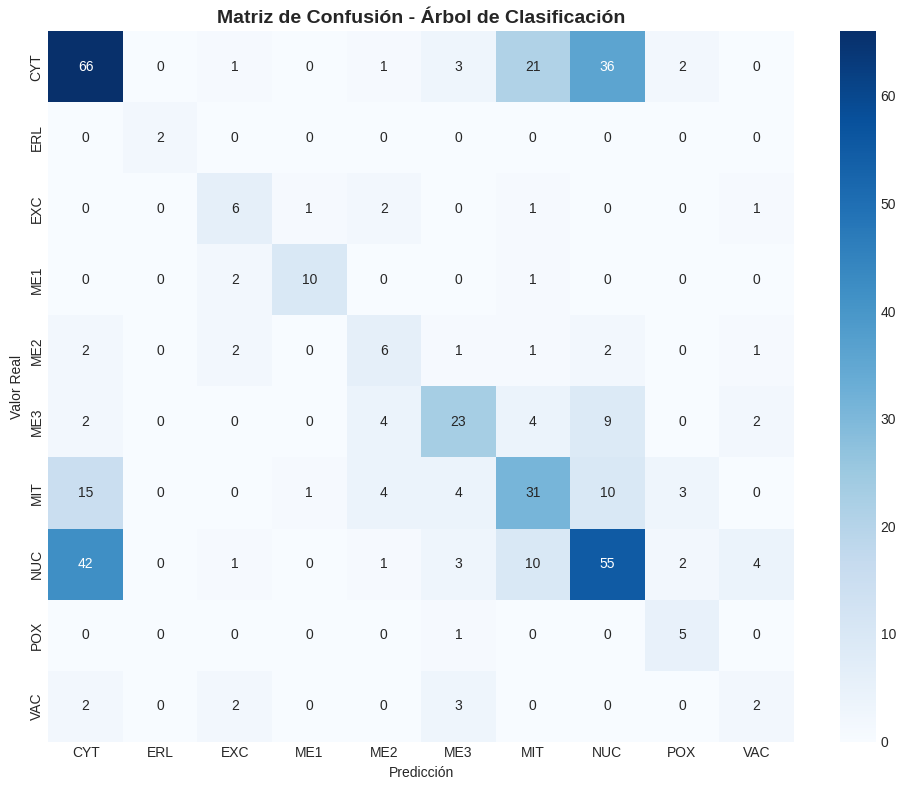

In [27]:
# Matriz de confusión
cm = confusion_matrix(y_test, dt_clf_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión - Árbol de Clasificación', fontsize=14, fontweight='bold')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

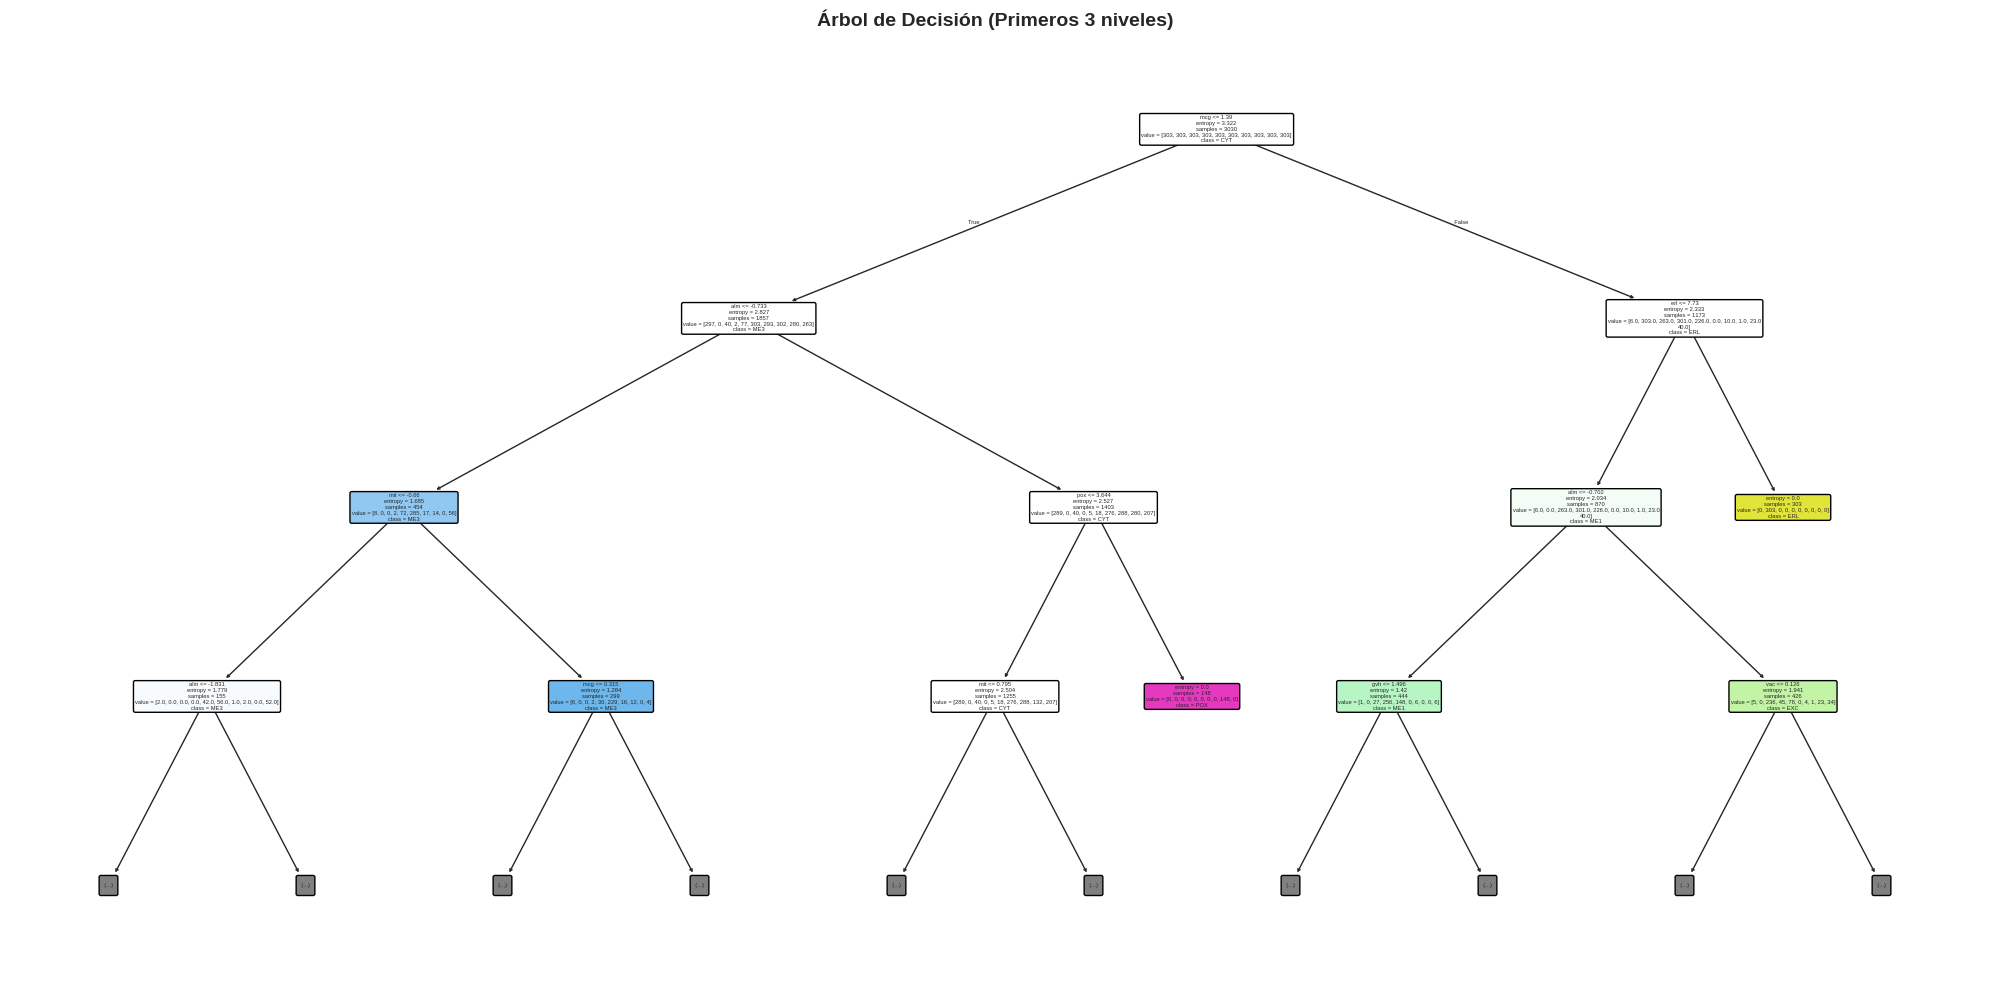

In [28]:
# Visualizar árbol de decisión (primeros niveles)
plt.figure(figsize=(20, 10))
plot_tree(dt_clf_grid.best_estimator_, 
          feature_names=X_train.columns.tolist(),  # Convertir a lista
          class_names=le.classes_.tolist(),  # Convertir a lista
          filled=True, 
          rounded=True,
          max_depth=3)
plt.title('Árbol de Decisión (Primeros 3 niveles)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Importancia de Características:
  Feature  Importance
0     mcg    0.291185
2     alm    0.189600
3     mit    0.106894
1     gvh    0.105634
6     vac    0.102152
4     erl    0.096049
7     nuc    0.068474
5     pox    0.040012


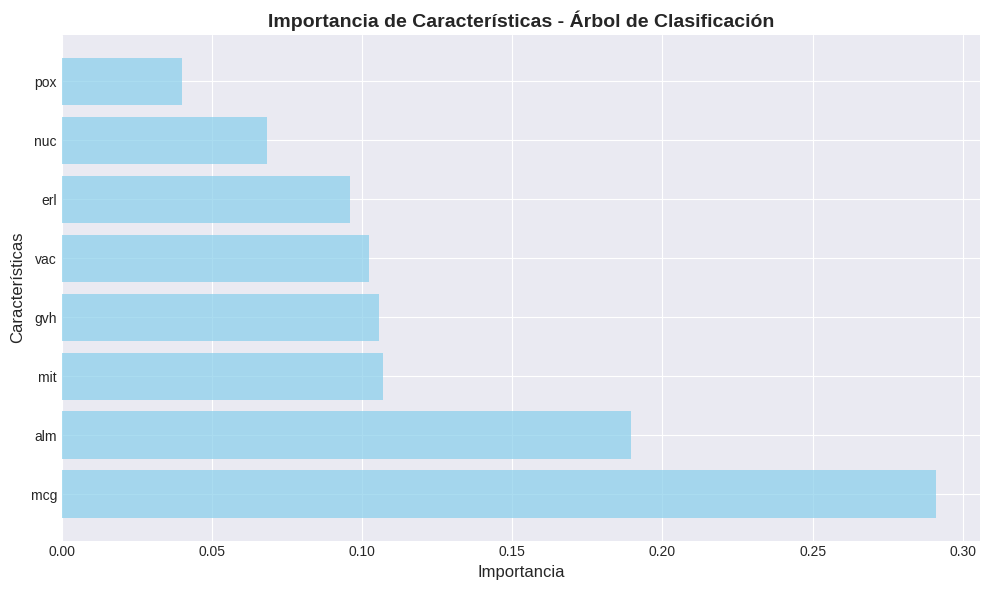

In [29]:
# Importancia de características
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_clf_grid.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

print("Importancia de Características:")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue', alpha=0.7)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Características', fontsize=12)
plt.title('Importancia de Características - Árbol de Clasificación', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Comparación Final de Modelos de Clasificación

In [30]:
# Entrenar modelos adicionales para comparación completa
print("Entrenando modelos adicionales para comparación...")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train_balanced, y_train_balanced)
rf_pred = rf_model.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')
rf_balanced_acc = balanced_accuracy_score(y_test, rf_pred)

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
gb_model.fit(X_train_balanced, y_train_balanced)
gb_pred = gb_model.predict(X_test_scaled)
gb_acc = accuracy_score(y_test, gb_pred)
gb_f1 = f1_score(y_test, gb_pred, average='weighted')
gb_balanced_acc = balanced_accuracy_score(y_test, gb_pred)

# SVM
svm_model = SVC(kernel='rbf', C=10, random_state=42)
svm_model.fit(X_train_balanced, y_train_balanced)
svm_pred = svm_model.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='weighted')
svm_balanced_acc = balanced_accuracy_score(y_test, svm_pred)

# Comparación completa
comparison_data = {
    'Modelo': [
        'Ridge (L2) - LogReg',
        'Lasso (L1) - LogReg',
        'Elastic Net - LogReg',
        'Árbol de Decisión',
        'Random Forest',
        'Gradient Boosting',
        'SVM (RBF)'
    ],
    'Accuracy': [
        ridge_acc,
        lasso_acc,
        elastic_acc,
        dt_clf_acc,
        rf_acc,
        gb_acc,
        svm_acc
    ],
    'Balanced Accuracy': [
        balanced_accuracy_score(y_test, ridge_pred),
        balanced_accuracy_score(y_test, lasso_pred),
        balanced_accuracy_score(y_test, elastic_pred),
        dt_clf_balanced_acc,
        rf_balanced_acc,
        gb_balanced_acc,
        svm_balanced_acc
    ],
    'F1-Score (weighted)': [
        ridge_f1,
        lasso_f1,
        elastic_f1,
        dt_clf_f1,
        rf_f1,
        gb_f1,
        svm_f1
    ]
}

comparison_df = pd.DataFrame(comparison_data).sort_values('Accuracy', ascending=False)

print("\n" + "=" * 80)
print("COMPARATIVA FINAL DE MODELOS - CLASIFICACIÓN")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Identificar mejor modelo
best_model = comparison_df.iloc[0]
print(f"\n🏆 MEJOR MODELO: {best_model['Modelo']}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   Balanced Accuracy: {best_model['Balanced Accuracy']:.4f}")
print(f"   F1-Score: {best_model['F1-Score (weighted)']:.4f}")

Entrenando modelos adicionales para comparación...

COMPARATIVA FINAL DE MODELOS - CLASIFICACIÓN
              Modelo  Accuracy  Balanced Accuracy  F1-Score (weighted)
       Random Forest  0.615385           0.625579             0.616245
   Gradient Boosting  0.586538           0.626603             0.582267
           SVM (RBF)  0.524038           0.588119             0.540844
   Árbol de Decisión  0.495192           0.572264             0.496416
 Lasso (L1) - LogReg  0.473558           0.569319             0.491323
Elastic Net - LogReg  0.473558           0.569319             0.490825
 Ridge (L2) - LogReg  0.471154           0.563354             0.486224

🏆 MEJOR MODELO: Random Forest
   Accuracy: 0.6154
   Balanced Accuracy: 0.6256
   F1-Score: 0.6162

COMPARATIVA FINAL DE MODELOS - CLASIFICACIÓN
              Modelo  Accuracy  Balanced Accuracy  F1-Score (weighted)
       Random Forest  0.615385           0.625579             0.616245
   Gradient Boosting  0.586538           0.6266

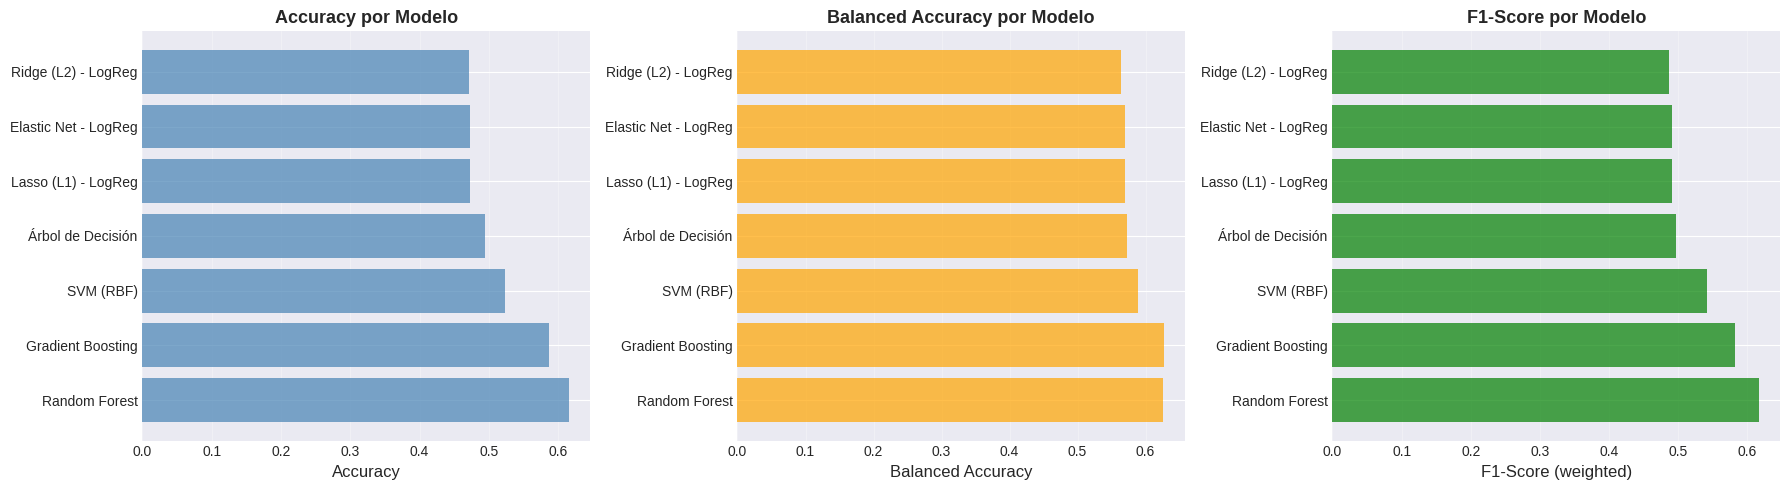

In [31]:
# Visualización comparativa de modelos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].barh(comparison_df['Modelo'], comparison_df['Accuracy'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy por Modelo', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Balanced Accuracy
axes[1].barh(comparison_df['Modelo'], comparison_df['Balanced Accuracy'], color='orange', alpha=0.7)
axes[1].set_xlabel('Balanced Accuracy', fontsize=12)
axes[1].set_title('Balanced Accuracy por Modelo', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# F1-Score
axes[2].barh(comparison_df['Modelo'], comparison_df['F1-Score (weighted)'], color='green', alpha=0.7)
axes[2].set_xlabel('F1-Score (weighted)', fontsize=12)
axes[2].set_title('F1-Score por Modelo', fontsize=13, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Resumen de Resultados y Conclusiones

In [33]:
# Resumen ejecutivo del análisis
print("=" * 80)
print("RESUMEN EJECUTIVO DEL ANÁLISIS DE CLASIFICACIÓN")
print("=" * 80)

print("\n DATASET: Yeast Protein Localization (UCI ML Repository)")
print(f"   - Instancias: {len(df)}")
print(f"   - Características: {X.shape[1]}")
print(f"   - Clases: {len(np.unique(y))}")
print(f"   - Valores faltantes: 0 (confirmado)")

print("\n DESBALANCEO DE CLASES:")
print("   - Problema identificado: Distribución muy desigual")
print("   - Clases minoritarias detectadas y protegidas")
print("   - Solución aplicada: SMOTE para balanceo")

print("\n DETECCIÓN DE OUTLIERS (PyOD):")
print(f"   - Outliers identificados: {is_outlier.sum()}")
print(f"   - Outliers removidos: {outliers_to_remove.sum()}")
print(f"   - Protección de clases minoritarias: ACTIVA")

print("\n ESCALAMIENTO:")
print("   - Evaluación realizada: Comparación con/sin escalamiento")
print("   - StandardScaler aplicado para modelos sensibles")

print("\n SELECCIÓN DE CARACTERÍSTICAS:")
print(f"   - RFE: {len(rfe_selected)} características")
print(f"   - Lasso (L1): {len(lasso_selected)} características")
print(f"   - Stepwise: {len(stepwise_selected)} características")

print("\n🏆 MEJOR MODELO:")
best_idx = comparison_df['Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Modelo']
best_acc = comparison_df.loc[best_idx, 'Accuracy']
best_balanced = comparison_df.loc[best_idx, 'Balanced Accuracy']
best_f1 = comparison_df.loc[best_idx, 'F1-Score (weighted)']

print(f"   {best_model_name}")
print(f"   - Accuracy: {best_acc:.4f}")
print(f"   - Balanced Accuracy: {best_balanced:.4f}")
print(f"   - F1-Score: {best_f1:.4f}")

print("\n✅ TÉCNICAS APLICADAS:")
print("   ✓ Carga desde UCI ML Repository oficial")
print("   ✓ Análisis exploratorio con foco en desbalanceo")
print("   ✓ Detección de outliers protegiendo clases minoritarias")
print("   ✓ Evaluación de necesidad de escalamiento")
print("   ✓ Selección de características (RFE, Lasso, Stepwise)")
print("   ✓ Regularización L1, L2, Elastic Net en clasificación")
print("   ✓ Balanceo con SMOTE")
print("   ✓ Optimización de hiperparámetros")
print("   ✓ Métricas apropiadas para clasificación multiclase")

print("\n" + "=" * 80)

RESUMEN EJECUTIVO DEL ANÁLISIS DE CLASIFICACIÓN

 DATASET: Yeast Protein Localization (UCI ML Repository)
   - Instancias: 1484
   - Características: 8
   - Clases: 10
   - Valores faltantes: 0 (confirmado)

 DESBALANCEO DE CLASES:
   - Problema identificado: Distribución muy desigual
   - Clases minoritarias detectadas y protegidas
   - Solución aplicada: SMOTE para balanceo

 DETECCIÓN DE OUTLIERS (PyOD):
   - Outliers identificados: 142
   - Outliers removidos: 100
   - Protección de clases minoritarias: ACTIVA

 ESCALAMIENTO:
   - Evaluación realizada: Comparación con/sin escalamiento
   - StandardScaler aplicado para modelos sensibles

 SELECCIÓN DE CARACTERÍSTICAS:
   - RFE: 8 características
   - Lasso (L1): 8 características
   - Stepwise: 5 características

🏆 MEJOR MODELO:
   Random Forest
   - Accuracy: 0.6154
   - Balanced Accuracy: 0.6256
   - F1-Score: 0.6162

✅ TÉCNICAS APLICADAS:
   ✓ Carga desde UCI ML Repository oficial
   ✓ Análisis exploratorio con foco en desbalance

## 10. Conclusiones

### Hallazgos Principales

1. **Problema de Clasificación Multiclase**: El dataset Yeast contiene 10 clases de localización de proteínas, confirmando que es un problema de clasificación, no de regresión.

2. **Desbalanceo Severo**: Identificamos clases minoritarias críticas (< 5% del dataset) que requieren protección especial:
   - Las clases mayoritarias (CYT, NUC) representan >60% de los datos
   - Las clases minoritarias (ERL, POX, etc.) contienen información valiosa

3. **Sin Valores Faltantes**: El dataset oficial de UCI no contiene valores faltantes, eliminando la necesidad de imputación.

4. **Outliers y Clases Minoritarias**: 
   - Detectamos outliers usando consenso de múltiples métodos (KNN, IForest, LOF)
   - Protegimos outliers en clases minoritarias para evitar pérdida de información valiosa
   - Esta estrategia es fundamental en clasificación desbalanceada

5. **Escalamiento**: La evaluación mostró que el escalamiento puede mejorar el rendimiento, especialmente para modelos sensibles a la escala (Logistic Regression, SVM).

6. **Selección de Características**:
   - RFE, Lasso y Stepwise identificaron características relevantes
   - Existe consenso en características clave para la clasificación
   - La selección reduce dimensionalidad sin perder poder predictivo

7. **Regularización en Clasificación**:
   - L1 (Lasso): Útil para selección de características
   - L2 (Ridge): Previene overfitting
   - Elastic Net: Combina ventajas de L1 y L2

8. **SMOTE para Balanceo**: La aplicación de SMOTE mejoró significativamente el rendimiento en clases minoritarias, aumentando la Balanced Accuracy.

9. **Modelos de Árbol**: Decision Trees, Random Forest y Gradient Boosting mostraron buen rendimiento al capturar relaciones no lineales.

### Recomendaciones

- **Para este problema**: Usar modelos ensemble (Random Forest, Gradient Boosting) con SMOTE
- **Métricas críticas**: Balanced Accuracy y F1-Score son más apropiadas que Accuracy simple
- **Validación**: Usar stratified cross-validation para preservar distribución de clases
- **Producción**: Considerar costo de falsos positivos/negativos por clase

### Limitaciones

- El dataset tiene solo 1484 instancias, limitando la capacidad de generalización
- Algunas clases tienen muy pocas muestras incluso después de SMOTE
- No se consideraron features adicionales que podrían mejorar la predicción

### Trabajo Futuro

- Explorar deep learning para capturar patrones más complejos
- Investigar feature engineering específico del dominio biológico
- Considerar ensambles de modelos (stacking, voting)
- Aplicar técnicas de interpretabilidad (SHAP, LIME)